### EDA 2
----
#### TODOs

\[ ] Find occluded pieces

\[ ] build a semi solid processing pipelines

\[ ] build image util libraries + savoire faire

#### Processing pipeline

 \[ ] crop

 \[ ] merge images and annotations

 \[ ] add padding to the images

 \[ ] resize the cropped images

 \[ ] save the images

In [8]:
import numpy as np
import os, sys, json
import PIL
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

img_dir = '../../rf-chess-data/roboflow/export/'
img_fns = os.listdir(img_dir)

annotate_fn = '_annotations.coco.json'

with open(Path(img_dir, annotate_fn), 'r') as f:
    d_annotate = json.load(f)
    
d_annotate.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

##### Pandas: annotations left joined to images `df_join`

In [9]:
df_annotate = pd.DataFrame(d_annotate['annotations'])
df_annotate.head(3)

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,10,"[959, 767, 107, 161]",17227,[],0
1,1,1,5,"[1127, 229, 129, 257]",33153,[],0
2,2,2,4,"[1163, 614, 104, 154]",16016,[],0


In [10]:
df_images = pd.DataFrame(d_annotate['images'])
df_images.head(3)

,id,license,file_name,height,width,date_captured
0,0,1,0301b7f9ed4d5ba503fda79fc4370c29.jpg,1529,2284,2020-02-11T17:18:56+00:00
1,1,1,00bc0cacffdebe6b11bdeec56f63ee49.jpg,1529,2284,2020-02-11T17:18:56+00:00
2,2,1,03886821377011fec599e8fa12d86e89.jpg,1529,2284,2020-02-11T17:18:56+00:00


In [11]:
df_categories = pd.DataFrame(d_annotate['categories'])
df_categories.head(3)

,id,name,supercategory
0,0,pieces,none
1,1,black-bishop,pieces
2,2,black-king,pieces


In [13]:
df_join = pd.merge(df_annotate, 
                   df_images,
                   how='left',
                   left_on='image_id',
                   right_on='id'
                  )

In [14]:
print(df_images.shape, df_annotate.shape, df_join.shape)

(289, 6) (2870, 7) (2870, 13)


In [15]:
df_join.head(3)

,id_x,image_id,category_id,bbox,area,segmentation,iscrowd,id_y,license,file_name,height,width,date_captured
0,0,0,10,"[959, 767, 107, 161]",17227,[],0,0,1,0301b7f9ed4d5ba503fda79fc4370c29.jpg,1529,2284,2020-02-11T17:18:56+00:00
1,1,1,5,"[1127, 229, 129, 257]",33153,[],0,1,1,00bc0cacffdebe6b11bdeec56f63ee49.jpg,1529,2284,2020-02-11T17:18:56+00:00
2,2,2,4,"[1163, 614, 104, 154]",16016,[],0,2,1,03886821377011fec599e8fa12d86e89.jpg,1529,2284,2020-02-11T17:18:56+00:00


In [ ]:
np.sqrt()

##### Validity Checks + EDA

 - are all images the same size? -> yes
 - what is the smallest piece, the largest piece? -> 107 - 273 px^(1/2)
 - average piece size? -> 160 px^2
 - transfrom bbox -> 4cols?
 - how to find occlusions with bounding boxes?
 - summarize high level facts on data:
 
```   
   ~ 3,000 annotations on ~300 images
   of C classes, with a roughly balanced (?) incidience
   
```

In [22]:
df_join.isnull().sum().sum()

0

In [23]:
df_join['iscrowd'].sum()

0

In [24]:
df_join['height'].min(), df_join['height'].max()

(1529, 1529)

In [25]:
df_join['width'].min(), df_join['width'].max()

(2284, 2284)

min: 107.0
max: 273.0
mean: 166.0


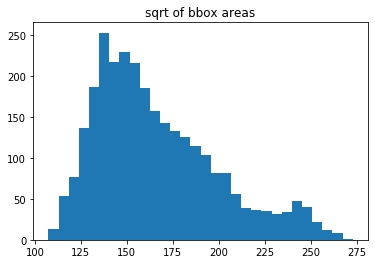

In [86]:
areas = np.sqrt(df_join['area'])

msg =  f"min: {round(areas.min(),0)}\n"
msg += f"max: {round(areas.max(),0)}\n"
msg += f"mean: {round(areas.mean(),0)}"
print(msg)

plt.hist(areas,bins=30);
plt.title('sqrt of bbox areas');

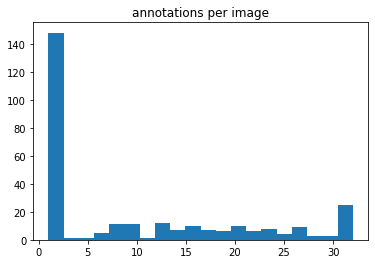

In [47]:
ann_per_img = (df_join.groupby(['image_id'])
               .agg(['count']).iloc[:,0])
plt.hist(ann_per_img, bins=20)
plt.title('annotations per image');

In [70]:
ann_per_class = pd.DataFrame(
                 df_join.groupby(['category_id'])
                 .agg(['count']).iloc[:,0])

ann_per_class.columns = (ann_per_class.columns
                         .get_level_values(1))

ann_per_class = ann_per_class.join(
                    df_categories.set_index('id'))

In [81]:
tmp = ann_per_class.sort_values(by='count', 
                                ascending=False)
tmp

,count,name,supercategory
category_id,,,
4,659,black-pawn,pieces
10,639,white-pawn,pieces
6,201,black-rook,pieces
3,196,black-knight,pieces
9,184,white-knight,pieces
12,184,white-rook,pieces
7,172,white-bishop,pieces
8,149,white-king,pieces
2,147,black-king,pieces


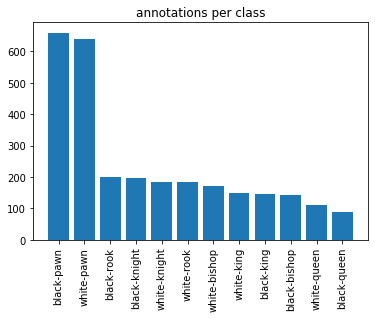

In [82]:
plt.bar(x=tmp['name'],
        height=tmp['count'])
plt.title('annotations per class')
plt.xticks(rotation='vertical');

##### Build some example rows to process

In [18]:
N = 10
example_rows = df_join[df_join['image_id'] < N]
print(example_rows.shape)
example_rows.head(3)

(80, 13)


,id_x,image_id,category_id,bbox,area,segmentation,iscrowd,id_y,license,file_name,height,width,date_captured
0,0,0,10,"[959, 767, 107, 161]",17227,[],0,0,1,0301b7f9ed4d5ba503fda79fc4370c29.jpg,1529,2284,2020-02-11T17:18:56+00:00
1,1,1,5,"[1127, 229, 129, 257]",33153,[],0,1,1,00bc0cacffdebe6b11bdeec56f63ee49.jpg,1529,2284,2020-02-11T17:18:56+00:00
2,2,2,4,"[1163, 614, 104, 154]",16016,[],0,2,1,03886821377011fec599e8fa12d86e89.jpg,1529,2284,2020-02-11T17:18:56+00:00


##### Example cropping

In [26]:
row = example_rows.iloc[0,:]
row

id_x                                                0
image_id                                            0
category_id                                        10
bbox                             [959, 767, 107, 161]
area                                            17227
segmentation                                       []
iscrowd                                             0
id_y                                                0
license                                             1
file_name        0301b7f9ed4d5ba503fda79fc4370c29.jpg
height                                           1529
width                                            2284
date_captured               2020-02-11T17:18:56+00:00
Name: 0, dtype: object

(1529, 2284, 3)


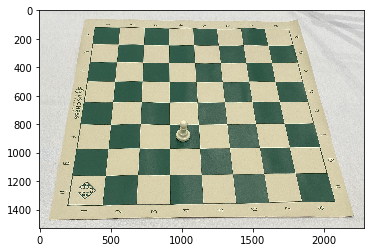

In [29]:
img_fn = row['file_name']
img_pil = PIL.Image.open(Path(img_dir, img_fn))
img_np = np.array(img_pil)
print(img_np.shape)
plt.imshow(img_np);

In [30]:
bbox = row['bbox']
lx, ly, w, h = bbox
crop_img = img_np[ly:ly+h,lx:lx+w ,:]

(161, 107, 3)


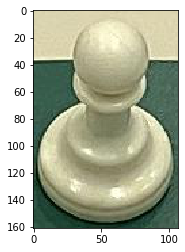

In [32]:
print(crop_img.shape)
plt.imshow(crop_img);

##### Demo cropping pipeline

In [125]:
def load_np_img(img_fn):
    img_pil = PIL.Image.open(Path(img_dir, img_fn))
    img_np = np.array(img_pil)
    return img_np

def crop_img(img, bbox):
    lx, ly, w, h = bbox
    return img[ly:ly+h,lx:lx+w ,:] 

In [133]:
crop_imgs, class_names = [], []

for _i in range(len(example_rows)):
    
    _row = example_rows.iloc[_i,:]
    
    img = load_np_img(_row['file_name'])
    
    img_cropped = crop_img(img, _row['bbox'])
    
    crop_imgs.append(img_cropped)
    class_names.append(_row['category_id'])


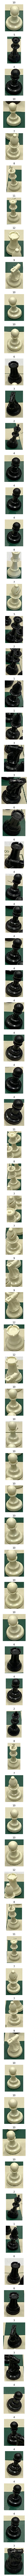

In [138]:
n = len(crop_imgs[:80])

fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(6, n*3))

for _i, (_img, _catid) in enumerate(
                            zip(crop_imgs, class_names)):
    ax[_i].imshow(_img)
    ax[_i].axis('off')
    ax[_i].title.set_text(str(_catid))
    
    if _i > n:
        break